In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from Exercise1_1 import LQRSolver
from torch.utils.data import TensorDataset, DataLoader

# Define matrices for LQR problem
H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=torch.double)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=torch.double)
sigma = torch.tensor([[[0.8],[1.1]]], dtype=torch.double)
C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=torch.double)
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=torch.double)
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=torch.double)
T = torch.tensor(1.0, dtype=torch.double)

# Initialize LQRSolver
lqr_solver = LQRSolver(H, M, sigma, C, D, R, T=T, method="euler")


In [2]:
# Generate training data
num_samples = 10000
t_samples = torch.rand(num_samples) * T
x_samples = (torch.rand(num_samples, 2) * 6 - 3).double()
x_samples_reshaped = x_samples.unsqueeze(1)

v_samples = lqr_solver.value_function(t_samples, x_samples_reshaped)


In [3]:
# Neural network for value function approximation
class ValueFunctionApproximator(nn.Module):
    def __init__(self):
        super(ValueFunctionApproximator, self).__init__()
        self.hidden = nn.Linear(3, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
    
    def forward(self, x):
        x = self.relu(self.hidden(x))
        return self.output(x)

model = ValueFunctionApproximator().double()


In [4]:
# Prepare for training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
inputs = torch.cat((t_samples.unsqueeze(-1), x_samples), dim=1)
dataset = TensorDataset(inputs, v_samples)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# List to store loss per epoch for plotting
epoch_losses = []

# Training loop
epochs = 101
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    epoch_losses.append(total_loss / len(dataloader))  # Store average loss for this epoch
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs} \t Loss: {total_loss / len(dataloader)}')


Epoch 0/101 	 Loss: 388.21981449571047
Epoch 10/101 	 Loss: 68.08198522077772
Epoch 20/101 	 Loss: 27.03733541875962
Epoch 30/101 	 Loss: 11.919829921486045
Epoch 40/101 	 Loss: 7.168110027598025
Epoch 50/101 	 Loss: 5.157664677289312
Epoch 60/101 	 Loss: 4.119769754222394
Epoch 70/101 	 Loss: 3.5385033105206865
Epoch 80/101 	 Loss: 3.1656375857625814
Epoch 90/101 	 Loss: 2.9233645695442148
Epoch 100/101 	 Loss: 2.665203044280638


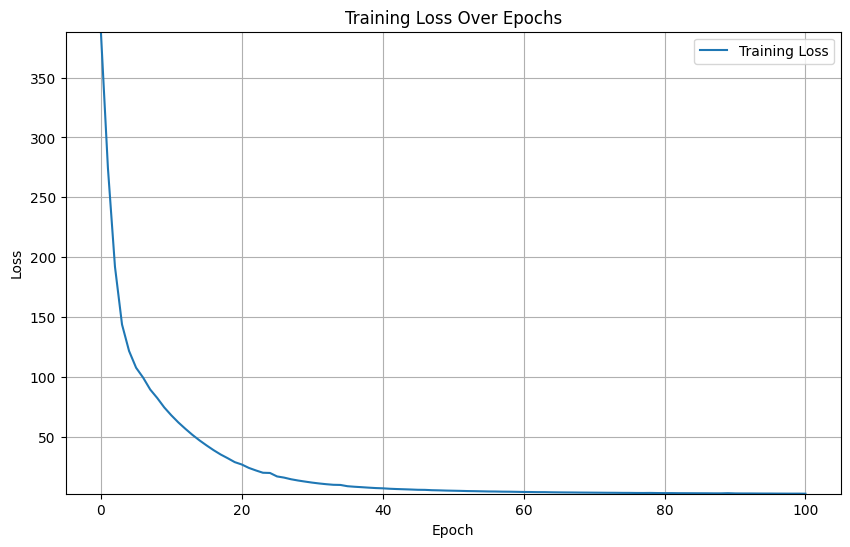

In [5]:
# Plotting the training loss with adjusted y-axis limits
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.ylim(min(epoch_losses)- 0.01, max(epoch_losses) + 0.01)  # Setting the y-axis limit to better visualize the decrease in loss
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

In [6]:
class MarkovControlNN(nn.Module):
    def __init__(self):
        super(MarkovControlNN, self).__init__()
        self.layer1 = nn.Linear(3, 100)  # Input to first hidden layer
        self.layer2 = nn.Linear(100, 100)  # First hidden to second hidden layer
        self.output_layer = nn.Linear(100, 2)  # Second hidden layer to output
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Initialize the model
model_control = MarkovControlNN().double()  # Use double precision to match input data type

In [7]:
# Assuming x_samples_reshaped and t_samples are already defined from the previous exercise

# Generate a_samples using the LQRSolver instance
a_samples = lqr_solver.markov_control(t_samples, x_samples_reshaped)


In [8]:
# Prepare data for DataLoader
inputs = torch.cat((t_samples.unsqueeze(-1), x_samples), dim=1)  # Combine t and x for NN input
dataset = TensorDataset(inputs, a_samples)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Training settings
optimizer = torch.optim.Adam(model_control.parameters(), lr=0.001)
criterion = nn.MSELoss()

# List to store loss per epoch for plotting
epoch_losses_control = []

# Training loop
epochs = 101
for epoch in range(epochs):
    model_control.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model_control(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_losses_control.append(total_loss / len(dataloader))
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs} \t Loss: {epoch_losses_control[-1]}')


c:\Users\warre\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1, 2])) that is different to the input size (torch.Size([128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\warre\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1, 2])) that is different to the input size (torch.Size([16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/101 	 Loss: 44.4624000363163
Epoch 10/101 	 Loss: 43.75694155054816
Epoch 20/101 	 Loss: 44.092154784683764
Epoch 30/101 	 Loss: 44.3151081900074
Epoch 40/101 	 Loss: 43.91856361857308
Epoch 50/101 	 Loss: 43.70030535664217
Epoch 60/101 	 Loss: 43.77276394735889
Epoch 70/101 	 Loss: 44.16530588078502
Epoch 80/101 	 Loss: 44.030394604763856
Epoch 90/101 	 Loss: 44.1376907930597
Epoch 100/101 	 Loss: 43.8259712210688


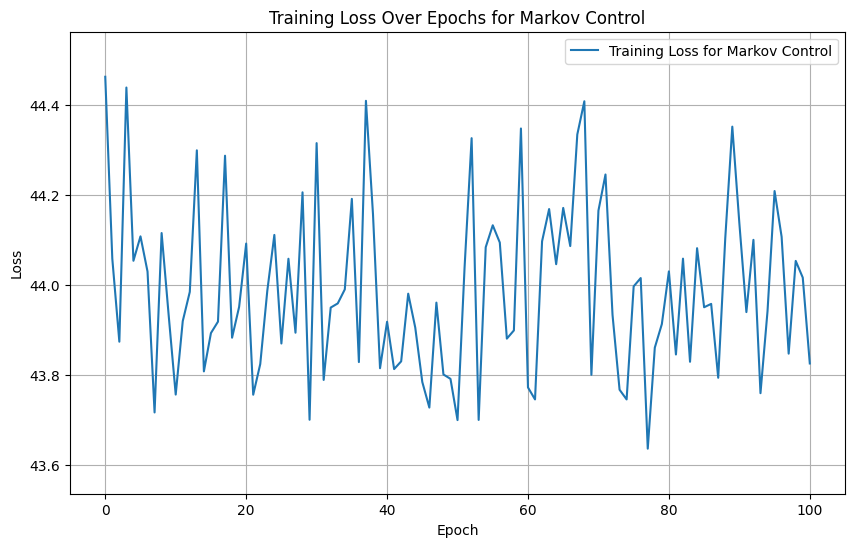

In [9]:
# Plotting the training loss for Markov control approximation
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_control, label='Training Loss for Markov Control')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for Markov Control')
plt.ylim(min(epoch_losses_control) - 0.1, max(epoch_losses_control) + 0.1)  # Adjust y-axis limit based on max loss
plt.legend()
plt.grid(True)
plt.show()